<a href="https://colab.research.google.com/github/TeneikaAskew/Formula1/blob/main/Random_Forest_and_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering



In [62]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shared drives/Projects/Clicked/F1'

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# Load your datasets (ensure the file paths are correct)
drivers = pd.read_csv('drivers.csv')
qualifying = pd.read_csv('qualifying.csv')
races = pd.read_csv('races.csv')
lap_times = pd.read_csv('lap_times.csv')
pit_stop_times = pd.read_csv('pit_stops.csv')
driver_standings = pd.read_csv('driver_standings.csv')
results = pd.read_csv('results.csv')
status = pd.read_csv('status.csv')
constructor_results = pd.read_csv('constructor_results.csv')
constructor_standings = pd.read_csv('constructor_standings.csv')

# Identify drivers who finished the races
finished_status_ids = status[status['status'].str.lower().isin(['finished', '1', 'active'])]['statusId'].unique()
finished_results = results[results['statusId'].isin(finished_status_ids)]

# Identify drivers who finished in the top 10 positions
finished_results['top_10'] = finished_results['positionOrder'] <= 10

# Merge races and results to get race year
results = results.merge(races[['raceId', 'year']], on='raceId', how='left')

# Calculate average position per season for each driver
seasonal_performance = results.groupby(['driverId', 'year'])['positionOrder'].mean().reset_index()
seasonal_performance.columns = ['driverId', 'year', 'avg_position_per_season']

# Calculate average qualifying position for each driver
qualifying['q1'] = qualifying['q1'].fillna('999:59.999').apply(lambda x: int(x.split(':')[0]) * 60 + float(x.split(':')[1]) if x != '\\N' else 999*60 + 59.999)
qualifying['q2'] = qualifying['q2'].fillna('999:59.999').apply(lambda x: int(x.split(':')[0]) * 60 + float(x.split(':')[1]) if x != '\\N' else 999*60 + 59.999)
qualifying['q3'] = qualifying['q3'].fillna('999:59.999').apply(lambda x: int(x.split(':')[0]) * 60 + float(x.split(':')[1]) if x != '\\N' else 999*60 + 59.999)
qualifying['qualifying_time'] = (qualifying['q1'] + qualifying['q2'] + qualifying['q3']) / qualifying[['q1', 'q2', 'q3']].notna().sum(axis=1)
avg_qualifying_position = qualifying.groupby('driverId')['position'].mean().reset_index()
avg_qualifying_position.columns = ['driverId', 'avg_qualifying_position']

# Calculate average team points
avg_team_points = constructor_results.groupby('constructorId')['points'].mean().reset_index()
avg_team_points.columns = ['constructorId', 'avg_team_points']

# Merge all performance metrics into results dataframe
results = results.merge(seasonal_performance, on=['driverId', 'year'], how='left')
results = results.merge(avg_qualifying_position, on='driverId', how='left')
results = results.merge(avg_team_points, on='constructorId', how='left')

# Create interaction features
results['qualifying_position_x_race_position'] = results['grid'] * results['positionOrder']
results['qualifying_position_x_team_points'] = results['grid'] * results['avg_team_points']

# Ensure the target variable exists
results['top_10'] = results['positionOrder'] <= 10
results['top_3'] = results['positionOrder'] <= 3

# Additional feature engineering
results['points_per_race'] = results['points'] / results['raceId'].map(results.groupby('raceId')['raceId'].count())
results['constructor_points_per_race'] = results['constructorId'].map(constructor_results.groupby('constructorId')['points'].mean())
results['driver_standing'] = results['driverId'].map(driver_standings.groupby('driverId')['points'].mean())
results['avg_pit_stop_time'] = pit_stop_times.groupby('raceId')['milliseconds'].transform('mean') / 1000  # converting ms to seconds
results['avg_lap_time'] = lap_times.groupby('raceId')['milliseconds'].transform('mean') / 1000  # converting ms to seconds

# Calculate the number of top 10 and top 3 finishes for each driver
top_10_counts = results.groupby('driverId')['top_10'].sum().reset_index()
top_3_counts = results.groupby('driverId')['top_3'].sum().reset_index()

top_10_counts.columns = ['driverId', 'top_10_count']
top_3_counts.columns = ['driverId', 'top_3_count']

results = results.merge(top_10_counts, on='driverId', how='left')
results = results.merge(top_3_counts, on='driverId', how='left')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shared drives/Projects/Clicked/F1


In [63]:
# Prepare the data for training
features = results[['grid', 'avg_position_per_season', 'avg_team_points', 'avg_qualifying_position',
                    'qualifying_position_x_race_position', 'qualifying_position_x_team_points',
                    'points_per_race', 'constructor_points_per_race', 'driver_standing',
                    'top_10_count', 'top_3_count', 'avg_pit_stop_time', 'avg_lap_time']]
target_top_10 = results['top_10']
target_top_3 = results['top_3']

# Drop any rows with missing values
features = features.dropna()
target_top_10 = target_top_10[features.index]
target_top_3 = target_top_3[features.index]



## Train Test Split

In [ ]:
# Split the data into training and testing sets for both targets
X_train, X_test, y_train_top_10, y_test_top_10 = train_test_split(features, target_top_10, test_size=0.2, random_state=42)
X_train_top_3, X_test_top_3, y_train_top_3, y_test_top_3 = train_test_split(features, target_top_3, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance for top 3 predictions
smote = SMOTE(random_state=42)
X_train_top_3_smote, y_train_top_3_smote = smote.fit_resample(X_train_top_3, y_train_top_3)

## Random Forest, Gradient Boosting and Ensemble Model


*   Hyperparameter Tuning
*   Grid Search



In [64]:
# Initialize the models with hyperparameter tuning
param_grid = {
    'rf__n_estimators': [50, 100, 200], #can reduce parameters if taking too long
    'gb__n_estimators': [50, 100, 200],
    'gb__learning_rate': [0.01, 0.1, 0.2]
}

rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
# gb_model = GradientBoostingClassifier(random_state=42, n_iter_no_change=5) Early Stopping for Gradient Boosting Use early stopping to reduce the number of iterations if no improvement is seen.

# Ensemble model
ensemble_model_top_10 = VotingClassifier(estimators=[('rf', rf_model), ('gb', gb_model)], voting='soft')
ensemble_model_top_3 = VotingClassifier(estimators=[('rf', rf_model), ('gb', gb_model)], voting='soft')

import multiprocessing
n_cpus = multiprocessing.cpu_count()
print(f"Number of CPUs: {n_cpus}")

# Hyperparameter tuning using GridSearchCV
grid_search_top_10 = GridSearchCV(estimator=ensemble_model_top_10, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=n_cpus)
grid_search_top_3 = GridSearchCV(estimator=ensemble_model_top_3, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=n_cpus)
grid_search_top_3_smote = GridSearchCV(estimator=ensemble_model_top_3, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=n_cpus)

Number of CPUs: 2


### Model Fit

In [65]:
# Fit the models - top 10
grid_search_top_10.fit(X_train, y_train_top_10)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('rf',
                                                     RandomForestClassifier(random_state=42)),
                                                    ('gb',
                                                     GradientBoostingClassifier(random_state=42))],
                                        voting='soft'),
             n_jobs=2,
             param_grid={'gb__learning_rate': [0.01, 0.1, 0.2],
                         'gb__n_estimators': [50, 100, 200],
                         'rf__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [66]:
# Fit the models - top 3 without SMOTE
grid_search_top_3.fit(X_train_top_3, y_train_top_3)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('rf',
                                                     RandomForestClassifier(random_state=42)),
                                                    ('gb',
                                                     GradientBoostingClassifier(random_state=42))],
                                        voting='soft'),
             n_jobs=2,
             param_grid={'gb__learning_rate': [0.01, 0.1, 0.2],
                         'gb__n_estimators': [50, 100, 200],
                         'rf__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [67]:
# # Fit the models - top 3 with SMOTE
#grid_search_top_3_smote = GridSearchCV(estimator=ensemble_model_top_3, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=n_cpus) #use cpus that are available (2)
grid_search_top_3_smote = GridSearchCV(estimator=ensemble_model_top_3, param_grid=param_grid, cv=5, n_jobs=-1)  # Use all available cores
grid_search_top_3_smote.fit(X_train_top_3_smote, y_train_top_3_smote)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('rf',
                                                     RandomForestClassifier(random_state=42)),
                                                    ('gb',
                                                     GradientBoostingClassifier(random_state=42))],
                                        voting='soft'),
             n_jobs=-1,
             param_grid={'gb__learning_rate': [0.01, 0.1, 0.2],
                         'gb__n_estimators': [50, 100, 200],
                         'rf__n_estimators': [50, 100, 200]})

#### Code Debugging

There are several factors that could be causing your grid search with SMOTE to take longer than other grid searches. Here's a breakdown of the potential reasons and how to address them:

1. SMOTE Itself:

    Data Expansion: SMOTE (Synthetic Minority Over-sampling Technique) artificially generates new samples for the minority class. This increases the size of your training dataset, directly impacting the time it takes for your models to train during the grid search.

2. Model Complexity:

    Ensemble Methods: If you're using complex ensemble methods (like Random Forest, Gradient Boosting) within your grid search, the training time will naturally increase. These models often involve fitting multiple base estimators.
    Hyperparameter Space: A larger hyperparameter search space (more parameters to tune and a wider range of values) means the grid search has to evaluate more combinations, leading to longer runtimes.

3. Data Size:

    Large Datasets: Even without SMOTE, larger datasets will always take longer to process. The combination of SMOTE and a large dataset can significantly amplify the training time.

4. Hardware Limitations:

    CPU/Memory Constraints: The speed of your computer's processor and the amount of available RAM directly affect how quickly the grid search can complete.

How to Diagnose and Improve:

    Time Profiling: Use Python's profiling tools (cProfile or line_profiler) to pinpoint the specific parts of your code that are consuming the most time. This will help you focus your optimization efforts.

    SMOTE Variations: Experiment with different SMOTE variants or other oversampling techniques. Some might be more computationally efficient for your specific dataset.

    Model Simplification: If possible, try simpler models or reduce the complexity of your ensemble methods (e.g., fewer trees in a Random Forest).

    Hyperparameter Space Reduction: Carefully analyze your hyperparameter space. Are there any parameters you can fix or narrow down the range for?

    Cross-Validation Folds: Reduce the number of cross-validation folds (the cv parameter in GridSearchCV) if it's feasible for your dataset.

    Hardware Upgrade: If your resources are very limited, consider upgrading your hardware (more RAM, faster CPU) for a substantial performance boost.

    Parallelization: If your hardware supports it, explore parallelizing your grid search



In [68]:
# import cProfile
# cProfile.run('grid_search_top_3_smote.fit(X_train_top_3_smote, y_train_top_3_smote)', 'grid_search_stats')
# import pstats
#    p = pstats.Stats('grid_search_stats')
#    p.sort_stats('cumulative').print_stats(20)  # Print top 20 most time-consuming functions
#!pip install line_profiler
# from line_profiler import LineProfiler

#    def my_grid_search():
#        grid_search_top_3_smote.fit(X_train_top_3_smote, y_train_top_3_smote)

#    lp = LineProfiler()
#    lp_wrapper = lp(my_grid_search)
#    lp_wrapper()

### Champion Model

In [69]:
# Best models
best_model_top_10 = grid_search_top_10.best_estimator_
best_model_top_3 = grid_search_top_3.best_estimator_
best_model_top_3_smote = grid_search_top_3_smote.best_estimator_

## Prediction/Performance Evaluations

In [70]:
# Predict and evaluate the model for top 10 finishes
y_pred_top_10 = best_model_top_10.predict(X_test)
accuracy_top_10 = accuracy_score(y_test_top_10, y_pred_top_10)
precision_top_10 = precision_score(y_test_top_10, y_pred_top_10)
recall_top_10 = recall_score(y_test_top_10, y_pred_top_10)
f1_top_10 = f1_score(y_test_top_10, y_pred_top_10)
class_report_top_10 = classification_report(y_test_top_10, y_pred_top_10)

print(f'Top 10 Accuracy: {accuracy_top_10}')
print(f'Top 10 Precision: {precision_top_10}')
print(f'Top 10 Recall: {recall_top_10}')
print(f'Top 10 F1 Score: {f1_top_10}')
print('Top 10 Classification Report:')
print(class_report_top_10)


# Predict and evaluate the model for top 3 finishes
y_pred_top_3 = best_model_top_3.predict(X_test_top_3)
accuracy_top_3 = accuracy_score(y_test_top_3, y_pred_top_3)
precision_top_3 = precision_score(y_test_top_3, y_pred_top_3)
recall_top_3 = recall_score(y_test_top_3, y_pred_top_3)
f1_top_3 = f1_score(y_test_top_3, y_pred_top_3)
class_report_top_3 = classification_report(y_test_top_3, y_pred_top_3)

print(f'Top 3 Accuracy: {accuracy_top_3}')
print(f'Top 3 Precision: {precision_top_3}')
print(f'Top 3 Recall: {recall_top_3}')
print(f'Top 3 F1 Score: {f1_top_3}')
print('Top 3 Classification Report:')
print(class_report_top_3)

# Predict and evaluate the model for top 3 finishes with SMOTE
y_pred_top_3_smote = best_model_top_3_smote.predict(X_test_top_3)
accuracy_top_3_smote = accuracy_score(y_test_top_3, y_pred_top_3_smote)
precision_top_3_smote = precision_score(y_test_top_3, y_pred_top_3_smote)
recall_top_3_smote = recall_score(y_test_top_3, y_pred_top_3_smote)
f1_top_3_smote = f1_score(y_test_top_3, y_pred_top_3_smote)
class_report_top_3_smote = classification_report(y_test_top_3, y_pred_top_3_smote)

print(f'Top 3 with SMOTE Accuracy: {accuracy_top_3_smote}')
print(f'Top 3 with SMOTE Precision: {precision_top_3_smote}')
print(f'Top 3 with SMOTE Recall: {recall_top_3_smote}')
print(f'Top 3 with SMOTE F1 Score: {f1_top_3_smote}')
print('Top 3 with SMOTE Classification Report:')
print(class_report_top_3_smote)

Top 10 Accuracy: 0.9993730407523511
Top 10 Precision: 1.0
Top 10 Recall: 0.9985380116959064
Top 10 F1 Score: 0.9992684711046086
Top 10 Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       911
        True       1.00      1.00      1.00       684

    accuracy                           1.00      1595
   macro avg       1.00      1.00      1.00      1595
weighted avg       1.00      1.00      1.00      1595

Top 3 Accuracy: 1.0
Top 3 Precision: 1.0
Top 3 Recall: 1.0
Top 3 F1 Score: 1.0
Top 3 Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1383
        True       1.00      1.00      1.00       212

    accuracy                           1.00      1595
   macro avg       1.00      1.00      1.00      1595
weighted avg       1.00      1.00      1.00      1595

Top 3 with SMOTE Accuracy: 0.9993730407523511
Top 3 with SMOTE Precision: 0.9953

# Predictions

In [78]:
# Create a list of driver names
driver_names = [
    'Hamilton', 'Verstappen', 'Leclerc', 'Russell', 'Pérez', 'Piastri', 'Sainz', 'Bearman', 'Hulkenberg'
    'Norris', 'Ricciardo', 'Alonso', 'Ocon', 'Gasly', 'Zhou', 'Bottas', 'Stroll', 'Tsunoda']

# Get the driver IDs for the given driver names
driver_ids = drivers[drivers['surname'].isin(driver_names)]['driverId'].tolist()

# Get the driver IDs for the given driver names
driver_ids = drivers[drivers['surname'].isin(driver_names)]['driverId'].tolist()
driver_ids.remove(708)  # Remove 708
driver_ids.remove(50)   # Remove 50

# Initialize lists to store predictions for the next race
predictions_top_10 = []
predictions_top_3 = []
predictions_top_3_smote = []

# Loop through each driver and make predictions for the next race
for driver_id in driver_ids:
    driver_name = drivers[drivers['driverId'] == driver_id]['surname'].values[0]

    # Get historical performance metrics
    driver_results = results[results['driverId'] == driver_id]
    driver_qualifying = qualifying[qualifying['driverId'] == driver_id]

    # Calculate average starting grid position
    avg_grid = driver_results['grid'].mean()

    # Calculate average finishing position per season
    avg_position_per_season = driver_results['positionOrder'].mean()

    # Calculate average qualifying position
    avg_qualifying_position = driver_qualifying['position'].mean()

    # Calculate the team points for the team the driver is currently in
    current_team_id = driver_results['constructorId'].values[-1]
    avg_team_points = constructor_results[constructor_results['constructorId'] == current_team_id]['points'].mean()

    # Calculate interaction features
    qualifying_position_x_race_position = avg_grid * avg_position_per_season
    qualifying_position_x_team_points = avg_grid * avg_team_points

    # Calculate the number of top 10 and top 3 finishes for the driver overall
    top_10_count = top_10_counts[top_10_counts['driverId'] == driver_id]['top_10_count'].values[0]
    top_3_count = top_3_counts[top_3_counts['driverId'] == driver_id]['top_3_count'].values[0]

    # Calculate average points per race
    points_per_race = driver_results['points_per_race'].mean()

    # Calculate average constructor points per race
    constructor_points_per_race = driver_results['constructor_points_per_race'].mean()

    # Calculate average driver standing
    driver_standing = driver_results['driver_standing'].mean()

    # Calculate average pit stop time and lap time
    avg_pit_stop_time = driver_results['avg_pit_stop_time'].mean()
    avg_lap_time = driver_results['avg_lap_time'].mean()

    # Compile feature values into a DataFrame
    driver_features = pd.DataFrame([{
        'grid': avg_grid,
        'avg_position_per_season': avg_position_per_season,
        'avg_team_points': avg_team_points,
        'avg_qualifying_position': avg_qualifying_position,
        'qualifying_position_x_race_position': qualifying_position_x_race_position,
        'qualifying_position_x_team_points': qualifying_position_x_team_points,
        'points_per_race': points_per_race,
        'constructor_points_per_race': constructor_points_per_race,
        'driver_standing': driver_standing,
        'top_10_count': top_10_count,
        'top_3_count': top_3_count,
        'avg_pit_stop_time': avg_pit_stop_time,
        'avg_lap_time': avg_lap_time
    }])

    # Handle NaN values by replacing them with the mean of the column
    #driver_features.fillna(driver_features.mean(), inplace=True) #still error
    driver_features.fillna(0, inplace=True)

    # Make predictions for top 10 and top 3 finishes
    prediction_top_10 = best_model_top_10.predict(driver_features)[0]
    prediction_top_3 = best_model_top_3.predict(driver_features)[0]
    prediction_top_3_smote = best_model_top_3_smote.predict(driver_features)[0]

    # Store predictions
    predictions_top_10.append((driver_name, prediction_top_10))
    predictions_top_3.append((driver_name, prediction_top_3))
    predictions_top_3_smote.append((driver_name, prediction_top_3_smote))

# Print predictions for all drivers
print("Predictions for the next race:")
print("\nTop 10 Predictions:")
for driver_name, pred_top_10 in predictions_top_10:
    print(f"Will {driver_name} place top 10: {pred_top_10}")
print("\nTop 3 Predictions:")
for driver_name, pred_top_3 in predictions_top_3:
    print(f"Will {driver_name} place top 3: {pred_top_3}")
print("\nTop 3 SMOTE Predictions:")
for driver_name, pred_top_3_smote in predictions_top_3_smote:
    print(f"Will {driver_name} place top 3: {pred_top_3}")

Predictions for the next race:

Top 10 Predictions:
Will Hamilton place top 10: True
Will Alonso place top 10: True
Will Gasly place top 10: True
Will Pérez place top 10: True
Will Ricciardo place top 10: True
Will Bottas place top 10: True
Will Verstappen place top 10: True
Will Sainz place top 10: True
Will Ocon place top 10: True
Will Stroll place top 10: True
Will Leclerc place top 10: True
Will Russell place top 10: True
Will Tsunoda place top 10: False
Will Zhou place top 10: False
Will Piastri place top 10: True
Will Bearman place top 10: True

Top 3 Predictions:
Will Hamilton place top 3: True
Will Alonso place top 3: True
Will Gasly place top 3: False
Will Pérez place top 3: True
Will Ricciardo place top 3: False
Will Bottas place top 3: True
Will Verstappen place top 3: True
Will Sainz place top 3: True
Will Ocon place top 3: False
Will Stroll place top 3: False
Will Leclerc place top 3: True
Will Russell place top 3: False
Will Tsunoda place top 3: False
Will Zhou place top 

### Stress Testing

In [85]:
# Perform 5-fold cross-validation for top 10 and top 3 models
cv_scores_top_10 = cross_val_score(best_model_top_10, features, target_top_10, cv=5, scoring='accuracy')
cv_scores_top_3 = cross_val_score(best_model_top_3, features, target_top_3, cv=5, scoring='accuracy')
cv_scores_top_3_smote = cross_val_score(best_model_top_3_smote, features, target_top_3, cv=5, scoring='accuracy')

print(f'Cross-Validation Scores for Top 10: {cv_scores_top_10}')
print(f'Mean Cross-Validation Score for Top 10: {cv_scores_top_10.mean()}')
print(f'Cross-Validation Scores for Top 3: {cv_scores_top_3}')
print(f'Mean Cross-Validation Score for Top 3: {cv_scores_top_3.mean()}')
print(f'Cross-Validation Scores for Top 3 SMOTE: {cv_scores_top_3_smote}')
print(f'Mean Cross-Validation Score for Top 3 SMOTE: {cv_scores_top_3_smote.mean()}')

# Additional Train-Test Splits for top 10 model
test_sizes = [0.1, 0.3, 0.4]
train_test_accuracies_top_10 = {}
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(features, target_top_10, test_size=test_size, random_state=42)
    best_model_top_10.fit(X_train, y_train)
    y_pred = best_model_top_10.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    train_test_accuracies_top_10[test_size] = accuracy

# Additional Train-Test Splits for top 3 model
train_test_accuracies_top_3 = {}
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(features, target_top_3, test_size=test_size, random_state=42)
    best_model_top_3.fit(X_train, y_train)
    y_pred = best_model_top_3.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    train_test_accuracies_top_3[test_size] = accuracy



# Additional Train-Test Splits for top 3 SMOTE model
train_test_accuracies_top_3_smote = {}
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(features, target_top_3, test_size=test_size, random_state=42)
    best_model_top_3_smote.fit(X_train, y_train)
    y_pred = best_model_top_3_smote.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    train_test_accuracies_top_3_smote[test_size] = accuracy

print(f'Train-Test Accuracies for Top 10: {train_test_accuracies_top_10}')
print(f'Train-Test Accuracies for Top 3: {train_test_accuracies_top_3}')
print(f'Train-Test Accuracies for Top 3 SMOTE: {train_test_accuracies_top_3_smote}')

Cross-Validation Scores for Top 10: [0.99874608 1.         0.99811912 0.99561129 0.99561129]
Mean Cross-Validation Score for Top 10: 0.9976175548589342
Cross-Validation Scores for Top 3: [0.97429467 1.         0.99874608 0.99122257 0.96802508]
Mean Cross-Validation Score for Top 3: 0.9864576802507837
Cross-Validation Scores for Top 3 SMOTE: [0.97241379 1.         0.99874608 0.99122257 0.96802508]
Mean Cross-Validation Score for Top 3 SMOTE: 0.9860815047021945
Train-Test Accuracies for Top 10: {0.1: 1.0, 0.3: 0.9991642290012537, 0.4: 0.9996865203761756}
Train-Test Accuracies for Top 3: {0.1: 1.0, 0.3: 0.9995821145006268, 0.4: 0.9987460815047022}
Train-Test Accuracies for Top 3 SMOTE: {0.1: 1.0, 0.3: 0.9991642290012537, 0.4: 0.9987460815047022}


In [86]:
import numpy as np
# Add noise to the features for robustness check
features_noisy_top_10 = features.copy()
noise_top_10 = np.random.normal(0, 0.1, features.shape)
features_noisy_top_10 += noise_top_10

# Split the noisy data for top 10 model
X_train, X_test, y_train, y_test = train_test_split(features_noisy_top_10, target_top_10, test_size=0.2, random_state=42)
best_model_top_10.fit(X_train, y_train)
y_pred = best_model_top_10.predict(X_test)
accuracy_noisy_top_10 = accuracy_score(y_test, y_pred)

# Add noise to the features for robustness check
features_noisy_top_3 = features.copy()
noise_top_3 = np.random.normal(0, 0.1, features.shape)
features_noisy_top_3 += noise_top_3

# Split the noisy data for top 3 model
X_train, X_test, y_train, y_test = train_test_split(features_noisy_top_3, target_top_3, test_size=0.2, random_state=42)
best_model_top_3.fit(X_train, y_train)
y_pred = best_model_top_3.predict(X_test)
accuracy_noisy_top_3 = accuracy_score(y_test, y_pred)

# Add noise to the features for robustness check
features_noisy_top_3_smote = features.copy()
noise_top_3_smote = np.random.normal(0, 0.1, features.shape)
features_noisy_top_3_smote += noise_top_3_smote

# Split the noisy data for top 3 model
X_train, X_test, y_train, y_test = train_test_split(features_noisy_top_3, target_top_3, test_size=0.2, random_state=42)
best_model_top_3_smote.fit(X_train, y_train)
y_pred = best_model_top_3_smote.predict(X_test)
accuracy_noisy_top_3_smote = accuracy_score(y_test, y_pred)

print(f'Accuracy for Top 10 with Noisy Data: {accuracy_noisy_top_10}')
print(f'Accuracy for Top 3 with Noisy Data: {accuracy_noisy_top_3}')
print(f'Accuracy for Top 3 SMOTE with Noisy Data: {accuracy_noisy_top_3_smote}')

Accuracy for Top 10 with Noisy Data: 0.9962382445141066
Accuracy for Top 3 with Noisy Data: 0.9987460815047022
Accuracy for Top 3 SMOTE with Noisy Data: 0.9987460815047022


### Feature Importance

                                Feature  RandomForest  GradientBoosting
6                       points_per_race      0.334120      5.640547e-01
4   qualifying_position_x_race_position      0.318613      2.273272e-01
0                                  grid      0.116174      2.083418e-01
5     qualifying_position_x_team_points      0.044425      1.799947e-04
1               avg_position_per_season      0.034902      2.160997e-05
11                    avg_pit_stop_time      0.026869      1.389179e-06
3               avg_qualifying_position      0.024325      5.890759e-13
2                       avg_team_points      0.022353      3.057972e-06
8                       driver_standing      0.020367      3.064681e-05
10                          top_3_count      0.018127      4.814592e-07
7           constructor_points_per_race      0.016978      5.174893e-06
9                          top_10_count      0.013587      3.313217e-05
12                         avg_lap_time      0.009159      7.592

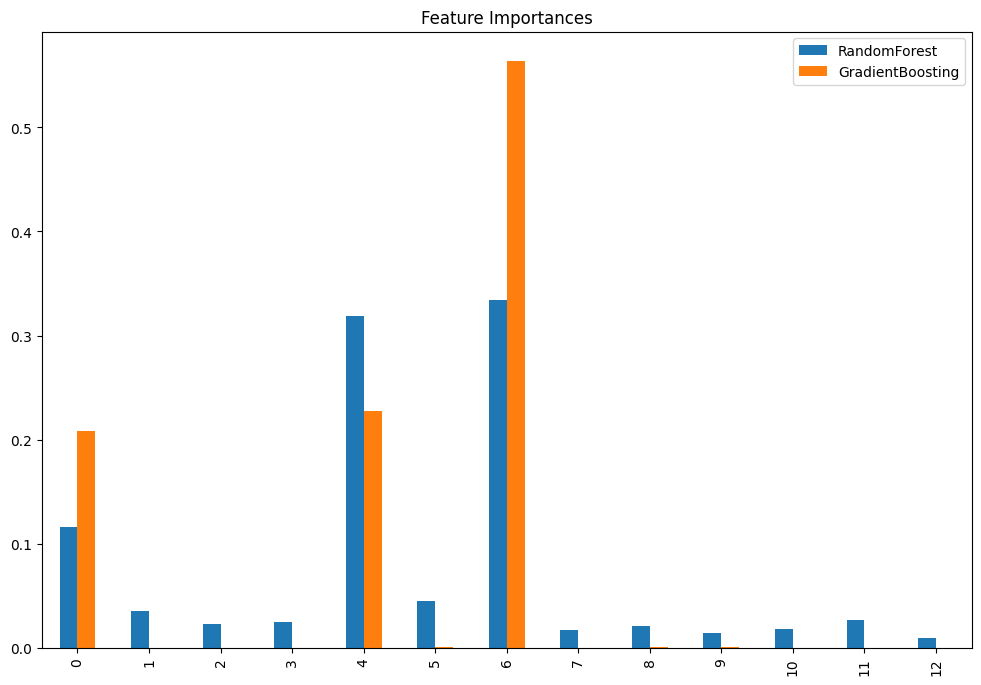

In [77]:
import matplotlib.pyplot as plt
# Check feature importances for the best models
rf_importances = best_model_top_10.named_estimators_['rf'].feature_importances_
gb_importances = best_model_top_10.named_estimators_['gb'].feature_importances_

# Create a DataFrame for feature importances
feature_names = features.columns
importances_df = pd.DataFrame({'Feature': feature_names, 'RandomForest': rf_importances, 'GradientBoosting': gb_importances})

print(importances_df.sort_values(by='RandomForest', ascending=False))
print(importances_df.sort_values(by='GradientBoosting', ascending=False))

importances_df.plot(kind='bar', figsize=(12, 8), title='Feature Importances')
plt.show()


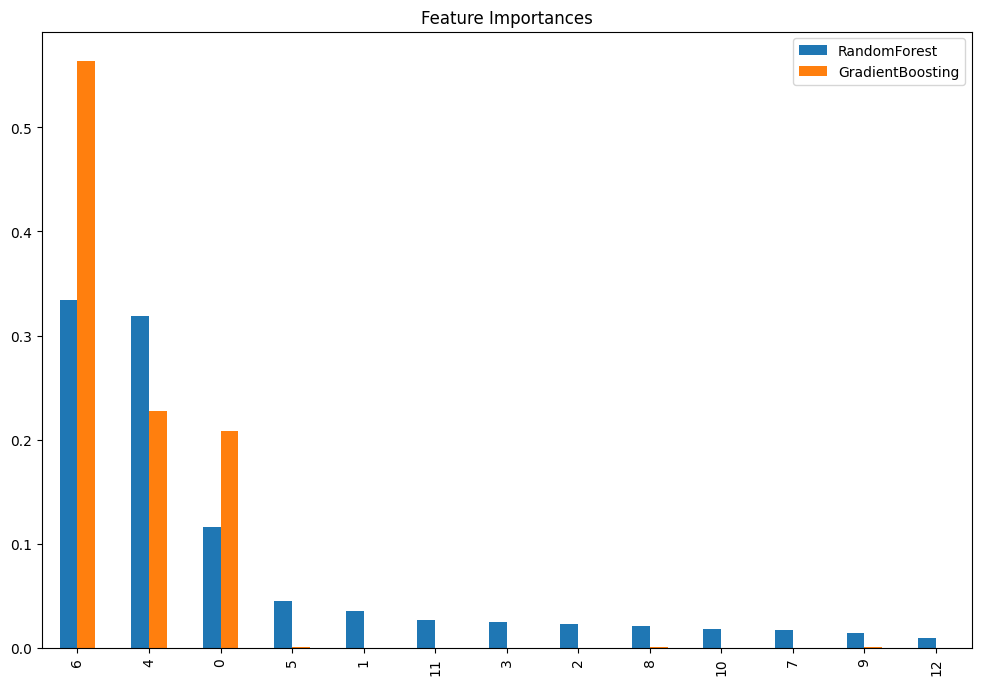

In [79]:
# prompt: sort these as well
# importances_df.plot(kind='bar', figsize=(12, 8), title='Feature Importances')
# plt.show()

import matplotlib.pyplot as plt
importances_df.sort_values(by=['RandomForest', 'GradientBoosting'], ascending=False).plot(kind='bar', figsize=(12, 8), title='Feature Importances')
plt.show()


# Summary

This model has high accuracy leading me to think there is some overfitting and may need rework soon.